<a href="https://colab.research.google.com/github/guitar79/OA-2018/blob/master/08_7_remove_bad_pixels_using_16bit_fits_mono.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**remove bad pixels**


* 이 자료는 천체사진을 위한 hot pixel과 dead pixel을 제거하는 방법에 대한 설명이다.

* python이 처음이라면 [Python Basic](https://colab.research.google.com/drive/1PCOoDIKypPVX9KTItMOht1cl96cPmeR_?authuser=1#scrollTo=3g6o04iLM0AF), [Python packages](https://colab.research.google.com/drive/1-1wx2VPEyNe11bmgpSpwdQgrJASCAqdH?authuser=1)를 먼저 학습하기를 권한다.

* package를 쉽게 설치하기 위해 Anaconda 사용을 권장한다.

경기과학고등학교 관측천문학 강좌를 위해 만들었으며  <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">크리에이티브 커먼즈 저작자표시-비영리-동일조건변경허락 4.0 국제 라이선스</a>에 따라 이용할 수 있음.

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="크리에이티브 커먼즈 라이선스" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a>

#Download data

fits 파일에서 hot pixel과 dead pixel을 제거해 보자.
[example fits files](https://drive.google.com/open?id=1guTGchioD5iD8tr1HOu0Qjjj_MjL-c-M)  파일을 다운받는다.

다운받은 사진은 적당한 폴더에 압축을 푼다. 

# bas pixel algorithm.

여기 알고리즘은 아래 자료를 참고하여 박관영 학생의 도움으로 버그를 바로 잡았다.

https://stackoverflow.com/questions/18951500/automatically-remove-hot-dead-pixels-from-an-image-in-python


In [1]:
!pip install astropy
#위 코드는 이곳 notebook에서만 필요합니다. 다른곳에서는 주석 처리하시기 바랍니다.

import numpy as np
import cv2
from astropy.io import fits
import os
import matplotlib.pyplot as plt

def fits_to_cv2(image_path):
    hdu = fits.open(image_path)
    data = hdu[0].data
    return np.array(data, dtype=np.uint16)
   
#https://stackoverflow.com/questions/18951500/automatically-remove-hot-dead-pixels-from-an-image-in-python
def find_outlier_pixels(data, tolerance=2.0, worry_about_edges=True):
    #This function finds the hot or dead pixels in a 2D dataset. 
    #tolerance is the number of standard deviations used to cutoff the hot pixels
    #If you want to ignore the edges and greatly speed up the code, then set
    #worry_about_edges to False.
    #The function returns a list of hot pixels and also an image with with hot pixels removed

    from scipy.ndimage import median_filter
    blurred = median_filter(data, size=2)  #size=2
    difference = np.array(data, dtype=np.int32) - np.array(blurred, dtype=np.int32)
    difference = np.array(abs(difference), dtype=np.uint16)

    threshold = tolerance*np.std(difference)

    #find the hot pixels, but ignore the edges
    hot_pixels = np.nonzero((np.abs(difference[1:-1,1:-1])>threshold) )
    hot_pixels = np.array(hot_pixels) + 1 #because we ignored the first row and first column

    fixed_image = np.copy(data) #This is the image with the hot pixels removed
    for y,x in zip(hot_pixels[0],hot_pixels[1]):
        fixed_image[y,x]=blurred[y,x]

    if worry_about_edges == True:
        height,width = np.shape(data)

        ###Now get the pixels on the edges (but not the corners)###

        #left and right sides
        for index in range(1,height-1):
            #left side:
            med  = np.median(data[index-1:index+2,0:2])
            diff = np.abs(data[index,0] - med)
            if diff>threshold: 
                hot_pixels = np.hstack(( hot_pixels, [[index],[0]]  ))
                fixed_image[index,0] = med

            #right side:
            med  = np.median(data[index-1:index+2,-2:])
            diff = np.abs(data[index,-1] - med)
            if diff>threshold: 
                hot_pixels = np.hstack(( hot_pixels, [[index],[width-1]]  ))
                fixed_image[index,-1] = med

        #Then the top and bottom
        for index in range(1,width-1):
            #bottom:
            med  = np.median(data[0:2,index-1:index+2])
            diff = np.abs(data[0,index] - med)
            if diff>threshold: 
                hot_pixels = np.hstack(( hot_pixels, [[0],[index]]  ))
                fixed_image[0,index] = med

            #top:
            med  = np.median(data[-2:,index-1:index+2])
            diff = np.abs(data[-1,index] - med)
            if diff>threshold: 
                hot_pixels = np.hstack(( hot_pixels, [[height-1],[index]]  ))
                fixed_image[-1,index] = med

        ###Then the corners###
        #bottom left
        med  = np.median(data[0:2,0:2])
        diff = np.abs(data[0,0] - med)
        if diff>threshold: 
            hot_pixels = np.hstack(( hot_pixels, [[0],[0]]  ))
            fixed_image[0,0] = med

        #bottom right
        med  = np.median(data[0:2,-2:])
        diff = np.abs(data[0,-1] - med)
        if diff>threshold: 
            hot_pixels = np.hstack(( hot_pixels, [[0],[width-1]]  ))
            fixed_image[0,-1] = med

        #top left
        med  = np.median(data[-2:,0:2])
        diff = np.abs(data[-1,0] - med)
        if diff>threshold: 
            hot_pixels = np.hstack(( hot_pixels, [[height-1],[0]]  ))
            fixed_image[-1,0] = med

        #top right
        med  = np.median(data[-2:,-2:])
        diff = np.abs(data[-1,-1] - med)
        if diff>threshold: 
            hot_pixels = np.hstack(( hot_pixels, [[height-1],[width-1]]  ))
            fixed_image[-1,-1] = med

    return hot_pixels,fixed_image

def save_fits_after_process(image_path, res_data):
    hdu = fits.open(image_path)
    hdu[0].data = res_data
    hdu.writeto(image_path[:-4]+'_bad_pixel_removed'+image_path[-4:], overwrite =True)
    if os.path.isfile(image_path[:-4]+'_bad_pixel_removed'+image_path[-4:]) :
        fits.setval(image_path[:-4]+'_bad_pixel_removed'+image_path[-4:], 'NOTES', value='processed by guitar79@naver.com')
        return print('bad_paxel_removed fits file is created')
    else : 
        return print('failure creating bad_paxel_removed fits file...')

아래와 같은 코드로 bad pixel을 제거할 수 있다.


bad_paxel_removed fits file is created


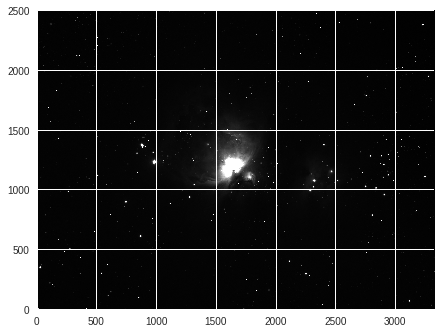

In [2]:
#start process
f_name = 'm42-003L.fit'

#identify bad pixel and fix image
cv2_data = fits_to_cv2(f_name)
hot_pixels,fixed_image = find_outlier_pixels(cv2_data)

#display on the screen
plt.imshow(fixed_image, interpolation='nearest', origin='lower', cmap = 'gray')

#write png file
cv2.imwrite(f_name[:-4]+'bad_pixel_removed.png', fixed_image)

#save fits file 
save_fits_after_process(f_name, fixed_image)


MaximDL에서 처리전과 처리후의 이미지를 열어 bad pixel이 지워졌는지 확인해 본다.

정리 차원에서 최종 코드를 첨부한다.

* [full code](https://github.com/guitar79/OA-2018/blob/master/08-7.remove_hot_pixel.py)